# Financial Fraud Detection EDA
 ---
 Elegí este dataset ya que trabajo en una fintech en donde hay una potencial mejora en el área de Fraud Detection/Risk. <br>
 El objetivo es identificar patrones que puedan indicar fraude y entrenar un modelo de Machine Learning para predecir dichas instancias.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [37]:
%pip install imblearn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 13.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=No

## Descripción del Dataset

El dataset contiene información sobre transacciones, comerciantes y clientes. Las principales características incluyen la cantidad de la transacción, la categoría de la transacción, la puntuación de anomalía y los indicadores de fraude.

## Data Acquisition
Levantamos los datos <br>
Si bien localmente tengo los datos descargardo, no los subo a github por tema de espacio, pero dejo el link del dataset público.
<br>
[Fraud Dataset link](https://www.kaggle.com/datasets/goyaladi/fraud-detection-dataset)

In [3]:
!ls ./work/data

'Customer Profiles'  'Fraudulent Patterns'   'Transaction Amounts'
 df_joined.csv	     'Merchant Information'  'Transaction Data'


### Carga de datos

In [4]:
#customer data
df_customer = pd.read_csv("./work/data/Customer Profiles/customer_data.csv")
df_account_activity = pd.read_csv("./work/data/Customer Profiles/account_activity.csv")

#fraudulent patterns
df_fraud = pd.read_csv("./work/data/Fraudulent Patterns/fraud_indicators.csv")
df_susp_activity = pd.read_csv("./work/data/Fraudulent Patterns/suspicious_activity.csv")

#merchant data
df_merchants = pd.read_csv("./work/data/Merchant Information/merchant_data.csv")
df_trx_cat_labels = pd.read_csv("./work/data/Merchant Information/transaction_category_labels.csv")

#transaction amounts
df_amounts = pd.read_csv("./work/data/Transaction Amounts/amount_data.csv")
df_anomaly_scores = pd.read_csv("./work/data/Transaction Amounts/anomaly_scores.csv")

#transaction data
df_trx_metadata = pd.read_csv("./work/data/Transaction Data/transaction_metadata.csv")
df_trx_records= pd.read_csv("./work/data/Transaction Data/transaction_records.csv")

In [5]:
def first_look_eda(df, name):
    print(f"Dataframe name: {name}")
    print("First 5 rows of the dataset")
    print(df.head())
    print("Data types of the columns")
    print(df.dtypes)
    print("Number of rows and columns")
    print(df.shape)
    print("Columns names")
    print(df.columns)
    print("Number of missing values")
    print(df.isnull().sum())
    print("Summary statistics")
    print(df.describe())
    print("Unique values")
    print(df.nunique())
    print("===============================================")

In [6]:
# dict with dataframe name and dataframe object
dataframes_dict = {"Customer Data": df_customer, "Account Activity": df_account_activity, "Fraud Indicators": df_fraud, "Suspicious Activity": df_susp_activity, "Merchant Data": df_merchants, "Transaction Category Labels": df_trx_cat_labels, "Amount Data": df_amounts, "Anomaly Scores": df_anomaly_scores, "Transaction Metadata": df_trx_metadata, "Transaction Records": df_trx_records} 

In [7]:
# uso la funcion first look para cada df
for name, df in dataframes_dict.items():
    first_look_eda(df, name)

Dataframe name: Customer Data
First 5 rows of the dataset
   CustomerID           Name  Age       Address
0        1001  Customer 1001   54  Address 1001
1        1002  Customer 1002   35  Address 1002
2        1003  Customer 1003   40  Address 1003
3        1004  Customer 1004   30  Address 1004
4        1005  Customer 1005   46  Address 1005
Data types of the columns
CustomerID     int64
Name          object
Age            int64
Address       object
dtype: object
Number of rows and columns
(1000, 4)
Columns names
Index(['CustomerID', 'Name', 'Age', 'Address'], dtype='object')
Number of missing values
CustomerID    0
Name          0
Age           0
Address       0
dtype: int64
Summary statistics
        CustomerID          Age
count  1000.000000  1000.000000
mean   1500.500000    39.892000
std     288.819436    13.524394
min    1001.000000    18.000000
25%    1250.750000    28.000000
50%    1500.500000    39.000000
75%    1750.250000    51.000000
max    2000.000000    64.000000
Unique

>Account Activity
>
>1. formateo campo LastLogin => object a date
>
>Transaction Metadata
>
>1. campo Timestamp => object a timestamp
>
><br>
> Excepto por esos campos en esos dataframes que les falta formato,
> no parecen existir datos nulos.

## Data Wrangling


Viendo que las tablas contienen IDs para relacionarlas armaré un join para obtener una tabla unica relacionada

In [8]:
# parto de las transacciones (Transaction Metadata)
df_join_1=df_trx_metadata.join(df_trx_records.set_index('TransactionID'), on='TransactionID', how='left')

In [9]:
# ahora agrego los montos (Amount Data)
df_join_2 = df_join_1.join(df_amounts.set_index('TransactionID'), on='TransactionID', how='left')

In [10]:
# ahora agrego las etiquetas de las categorias (Transaction Category Labels)
df_join_3 = df_join_2.join(df_trx_cat_labels.set_index('TransactionID'), on='TransactionID', how='left')

In [11]:
# agrego merchant data
df_join_4 = df_join_3.join(df_merchants.set_index('MerchantID'), on='MerchantID', how='left')

In [12]:
# agrego customer data
df_join_5 = df_join_4.join(df_customer.set_index('CustomerID'), on='CustomerID', how='left')

In [13]:
# agrego account activity del customer
df_join_6 = df_join_5.join(df_account_activity.set_index('CustomerID'), on='CustomerID', how='left')

In [14]:
# agrego anomaly scores
df_join_7 = df_join_6.join(df_anomaly_scores.set_index('TransactionID'), on='TransactionID', how='left')

In [15]:
# y por ultimo agrego los fraudulent patterns
df_join_8 = df_join_7.join(df_fraud.set_index('TransactionID'), on='TransactionID', how='left')
df_join_9 = df_join_8.join(df_susp_activity.set_index('CustomerID'), on='CustomerID', how='left')

In [16]:
# renombro la variable para que sea mas descriptiva
df_joined = df_join_9

In [17]:
# probemos pasar este nuevo df por la funcion first_look_eda
first_look_eda(df_joined, "Joined Data")

Dataframe name: Joined Data
First 5 rows of the dataset
   TransactionID            Timestamp  MerchantID     Amount  CustomerID  \
0              1  2022-01-01 00:00:00        2701  55.530334        1952   
1              2  2022-01-01 01:00:00        2070  12.881180        1027   
2              3  2022-01-01 02:00:00        2238  50.176322        1955   
3              4  2022-01-01 03:00:00        2879  41.634001        1796   
4              5  2022-01-01 04:00:00        2966  78.122853        1946   

   TransactionAmount Category   MerchantName       Location           Name  \
0          79.413607    Other  Merchant 2701  Location 2701  Customer 1952   
1          12.053087   Online  Merchant 2070  Location 2070  Customer 1027   
2          33.310357   Travel  Merchant 2238  Location 2238  Customer 1955   
3          46.121117   Travel  Merchant 2879  Location 2879  Customer 1796   
4          54.051618    Other  Merchant 2966  Location 2966  Customer 1946   

   Age       Addre

In [18]:
df_joined.shape

(1000, 17)

El dataset ahora tiene 1000 filas y 17 columnas. Aquí está la descripción inicial:

- trx_id: ID de la transacción (int64)
- trx_timestamp: Marca de tiempo de la transacción (object)
- merchant_id: ID del comerciante (int64)
- trx_amount: Monto de la transacción (float64)
- customer_id: ID del cliente (int64)
- amount_data_amount: Monto de los datos (float64)
- trx_category: Categoría de la transacción (object)
- merchant_name: Nombre del comerciante (object)
- merchant_location: Ubicación del comerciante (object)
- customer_name: Nombre del cliente (object)
- customer_age: Edad del cliente (int64)
- customer_address: Dirección del cliente (object)
- account_balance: Saldo de la cuenta (float64)
- account_last_login: Último inicio de sesión en la cuenta (object)
- anomaly_score: Puntuación de anomalía (float64)
- fraud_indicator: Indicador de fraude (int64)
- suspicious_flag: Bandera de sospecha (int64)

In [19]:
# chequeo si hay duplicados
df_joined.drop_duplicates().shape

(1000, 17)

In [20]:
# formateo los campos de fecha que eran LastLogin y Timestamp
df_joined['LastLogin'] = pd.to_datetime(df_joined['LastLogin'])

In [21]:
df_joined['Timestamp'] = pd.to_datetime(df_joined['Timestamp'])

In [22]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TransactionID      1000 non-null   int64         
 1   Timestamp          1000 non-null   datetime64[ns]
 2   MerchantID         1000 non-null   int64         
 3   Amount             1000 non-null   float64       
 4   CustomerID         1000 non-null   int64         
 5   TransactionAmount  1000 non-null   float64       
 6   Category           1000 non-null   object        
 7   MerchantName       1000 non-null   object        
 8   Location           1000 non-null   object        
 9   Name               1000 non-null   object        
 10  Age                1000 non-null   int64         
 11  Address            1000 non-null   object        
 12  AccountBalance     1000 non-null   float64       
 13  LastLogin          1000 non-null   datetime64[ns]
 14  AnomalySc

In [23]:
df_joined.head()

,TransactionID,Timestamp,MerchantID,Amount,CustomerID,TransactionAmount,Category,MerchantName,Location,Name,Age,Address,AccountBalance,LastLogin,AnomalyScore,FraudIndicator,SuspiciousFlag
0,1,2022-01-01 00:00:00,2701,55.530334,1952,79.413607,Other,Merchant 2701,Location 2701,Customer 1952,50,Address 1952,2869.689912,2024-08-09,0.686699,0,0
1,2,2022-01-01 01:00:00,2070,12.881180,1027,12.053087,Online,Merchant 2070,Location 2070,Customer 1027,46,Address 1027,9527.947107,2022-01-27,0.081749,0,0
2,3,2022-01-01 02:00:00,2238,50.176322,1955,33.310357,Travel,Merchant 2238,Location 2238,Customer 1955,34,Address 1955,9288.355525,2024-08-12,0.023857,0,0
3,4,2022-01-01 03:00:00,2879,41.634001,1796,46.121117,Travel,Merchant 2879,Location 2879,Customer 1796,33,Address 1796,5588.049942,2024-03-06,0.876994,0,0
4,5,2022-01-01 04:00:00,2966,78.122853,1946,54.051618,Other,Merchant 2966,Location 2966,Customer 1946,18,Address 1946,7324.785332,2024-08-03,0.034059,0,0


In [24]:
# renombro las columnas de df_joined para que sean mas descriptivas
df_joined.rename(columns={'TransactionID': 'trx_id',
                          'Timestamp': 'trx_timestamp',
                          'MerchantID': 'merchant_id',
                          'Amount': 'trx_amount',
                          'CustomerID': 'customer_id',
                          'TransactionAmount': 'amount_data_amount', 
                          'Category': 'trx_category', 
                          'MerchantName': 'merchant_name',
                          'Location': 'merchant_location', 
                          'Name': 'customer_name',
                          'Age': 'customer_age', 
                          'Address': 'customer_address', 
                          'AccountBalance': 'account_balance',
                          'LastLogin': 'account_last_login', 
                          'AnomalyScore': 'anomaly_score',
                          'FraudIndicator': 'fraud_indicator', 
                          'SuspiciousFlag': 'suspicious_flag'}, inplace=True)

In [25]:
df_joined.select_dtypes(include=['int64', 'float64']).columns

Index(['trx_id', 'merchant_id', 'trx_amount', 'customer_id',
       'amount_data_amount', 'customer_age', 'account_balance',
       'anomaly_score', 'fraud_indicator', 'suspicious_flag'],
      dtype='object')

## Análisis Exploratorio de Datos (EDA)

In [26]:
df = df_joined

In [27]:
# Análisis univariado
df.describe()

,trx_id,merchant_id,trx_amount,customer_id,amount_data_amount,customer_age,account_balance,anomaly_score,fraud_indicator,suspicious_flag
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,2504.701000,55.394871,1496.626000,55.853826,39.848000,5715.455931,0.492282,0.045000,0.025000
std,288.819436,288.414883,25.070809,289.229047,26.093606,13.074932,2540.517262,0.288423,0.207408,0.156203
min,1.000000,2001.000000,10.006933,1001.000000,10.057864,18.000000,1056.301181,0.000234,0.000000,0.000000
25%,250.750000,2254.500000,34.502315,1239.000000,33.875129,29.000000,3489.554711,0.251802,0.000000,0.000000
50%,500.500000,2500.500000,57.844325,1501.000000,55.958313,39.000000,5753.007775,0.490242,0.000000,0.000000
75%,750.250000,2761.250000,75.858576,1739.250000,77.589391,51.000000,7925.710167,0.741888,0.000000,0.000000
max,1000.000000,3000.000000,99.887410,2000.000000,99.784323,64.000000,9999.776239,0.999047,1.000000,1.000000


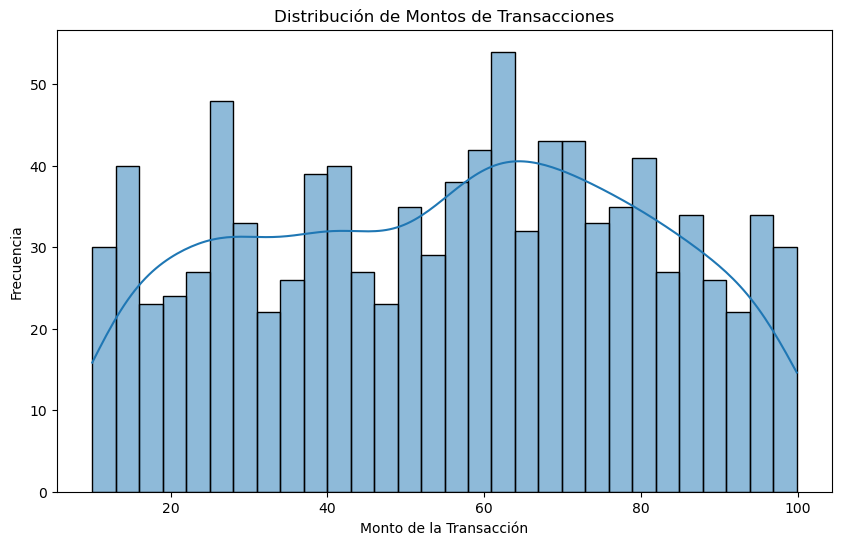

In [28]:
# Histograma de una variable numérica
plt.figure(figsize=(10, 6))
sns.histplot(df['trx_amount'], bins=30, kde=True)
plt.title('Distribución de Montos de Transacciones')
plt.xlabel('Monto de la Transacción')
plt.ylabel('Frecuencia')
plt.show()

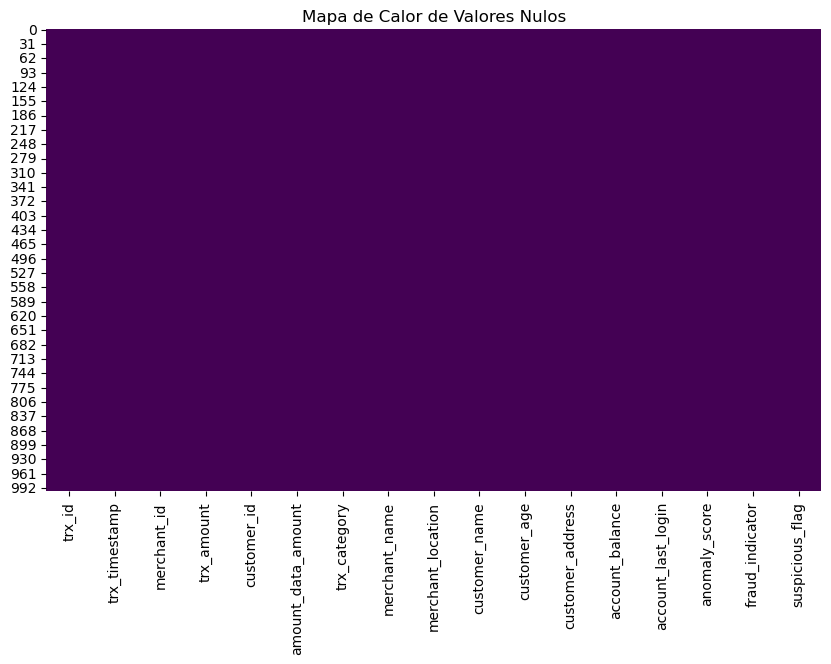

In [29]:
# Análisis de valores nulos
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de Calor de Valores Nulos')
plt.show()

/tmp/ipykernel_25351/2406891046.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


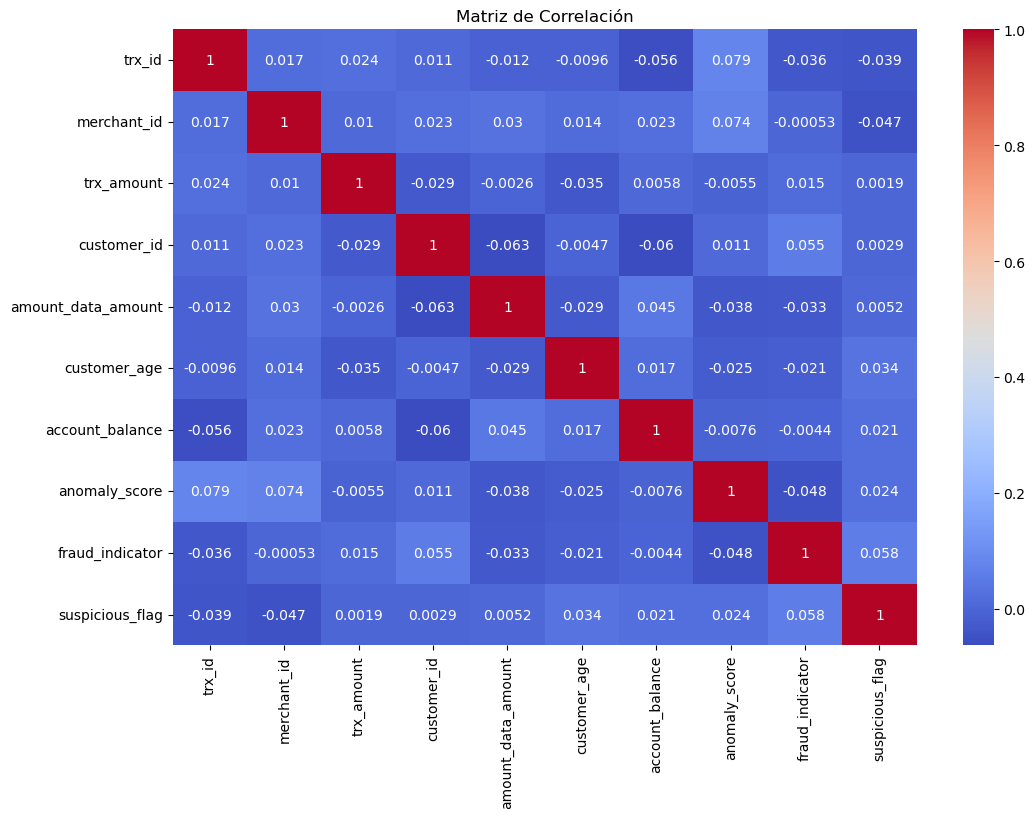

In [30]:
# Matriz de correlación
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

## Preprocesamiento de Datos
Primero, manejaremos los valores nulos, codificaremos las variables categóricas y dividiremos los datos en conjuntos de entrenamiento y prueba.
### Manejo de Valores Nulos
En este caso, no hay valores nulos en el dataset, por lo que no es necesario realizar imputaciones o eliminaciones.
### Codificación de Variables Categóricas
Utilizaremos `pd.get_dummies` para convertir las variables categóricas en variables dummy.
### División de Datos
Dividiremos los datos en conjuntos de entrenamiento y prueba utilizando **train_test_split** de **sklearn**.

In [31]:
# Codigo de Preprocesamiento
from sklearn.model_selection import train_test_split

# Convertir variables categoricas en variables dummy
df_encoded = pd.get_dummies(df, columns=['trx_category', 'merchant_name', 'merchant_location', 'customer_name', 'customer_address'])

# Definir caracteristicas (X) y etiquetas (y)
X = df_encoded.drop(columns=['trx_id', 'trx_timestamp', 'account_last_login', 'fraud_indicator'])
y = df_encoded['fraud_indicator']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)


Tamaño del conjunto de entrenamiento: (800, 2587)
Tamaño del conjunto de prueba: (200, 2587)


### Entrenamiento del Modelo (RandomForest)
Entrenaremos un modelo de Random Forest y evaluaremos su rendimiento inicial.

In [32]:
# Entrenamiento del Modelo
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Crear y entrenar el modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Evaluación del modelo
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nInforme de clasificación:\n", classification_report(y_test, y_pred))
print("Precisión:", accuracy_score(y_test, y_pred))


Matriz de confusión:
 [[193   0]
 [  7   0]]

Informe de clasificación:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       193
           1       0.00      0.00      0.00         7

    accuracy                           0.96       200
   macro avg       0.48      0.50      0.49       200
weighted avg       0.93      0.96      0.95       200

Precisión: 0.965


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ajuste del Modelo (Hyperparameter Tuning)
Realizaremos una búsqueda de hiperparámetros utilizando GridSearchCV.

In [33]:
# Ajuste del modelo con GridSearchCV
from sklearn.model_selection import GridSearchCV

# Definir el grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Mejor modelo y parámetros
best_rf_model = grid_search.best_estimator_
print("Mejores parámetros:", grid_search.best_params_)

# Evaluación del mejor modelo
y_pred_best = best_rf_model.predict(X_test)
print("Matriz de confusión del mejor modelo:\n", confusion_matrix(y_test, y_pred_best))
print("\nInforme de clasificación del mejor modelo:\n", classification_report(y_test, y_pred_best))
print("Precisión del mejor modelo:", accuracy_score(y_test, y_pred_best))


Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimator

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
205 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/opt/conda/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.11/site-packages/sklearn/util

Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Matriz de confusión del mejor modelo:
 [[193   0]
 [  7   0]]

Informe de clasificación del mejor modelo:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       193
           1       0.00      0.00      0.00         7

    accuracy                           0.96       200
   macro avg       0.48      0.50      0.49       200
weighted avg       0.93      0.96      0.95       200

Precisión del mejor modelo: 0.965


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Aplico estrategia de Oversampling con SMOTE
Para manejar el dataset desbalanceado, podemos usar técnicas de oversampling para mejorar el desempeño del modelo. Una de las técnicas más populares para esto es SMOTE (Synthetic Minority Over-sampling Technique), que genera muestras sintéticas de la clase minoritaria. <br>

Ahora aplicaremos SMOTE al conjunto de entrenamiento para balancear las clases y volveremos a entrenar el modelo para ver diferencias

In [34]:
# Recordamos como son los conjuntos de entrenamiento y prueba
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (800, 2587)
Tamaño del conjunto de prueba: (200, 2587)


In [35]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Crear y entrenar el modelo de Random Forest con datos balanceados
rf_model_smote = RandomForestClassifier(random_state=42)
rf_model_smote.fit(X_train_smote, y_train_smote)

# Predicciones en el conjunto de prueba
y_pred_smote = rf_model_smote.predict(X_test)

# Evaluación del modelo con datos balanceados
print("Matriz de confusión con SMOTE:\\n", confusion_matrix(y_test, y_pred_smote))
print("\\nInforme de clasificación con SMOTE:\\n", classification_report(y_test, y_pred_smote))
print("Precisión con SMOTE:", accuracy_score(y_test, y_pred_smote))


Matriz de confusión con SMOTE:\n [[177  16]
 [  7   0]]
\nInforme de clasificación con SMOTE:\n               precision    recall  f1-score   support

           0       0.96      0.92      0.94       193
           1       0.00      0.00      0.00         7

    accuracy                           0.89       200
   macro avg       0.48      0.46      0.47       200
weighted avg       0.93      0.89      0.91       200

Precisión con SMOTE: 0.885


In [36]:
# Ajuste del modelo con GridSearchCV
#from sklearn.model_selection import GridSearchCV

# Definir el grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf_model_smote, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Ajustar el modelo
grid_search.fit(X_train_smote, y_train_smote)

# Mejor modelo y parámetros
best_rf_model = grid_search.best_estimator_
print("Mejores parámetros luego de SMOTE:", grid_search.best_params_)

# Evaluación del mejor modelo
y_pred_best_smote = best_rf_model.predict(X_test)
print("Matriz de confusión del mejor modelo con SMOTE:\n", confusion_matrix(y_test, y_pred_best_smote))
print("\nInforme de clasificación del mejor modelo:\n", classification_report(y_test, y_pred_best_smote))
print("Precisión del mejor modelo con SMOTE:", accuracy_score(y_test, y_pred_best_smote))


Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
238 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/opt/conda/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.11/site-packages/sklearn/util

Mejores parámetros luego de SMOTE: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Matriz de confusión del mejor modelo con SMOTE:
 [[175  18]
 [  7   0]]

Informe de clasificación del mejor modelo:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       193
           1       0.00      0.00      0.00         7

    accuracy                           0.88       200
   macro avg       0.48      0.45      0.47       200
weighted avg       0.93      0.88      0.90       200

Precisión del mejor modelo con SMOTE: 0.875


### Entrenamiento del Modelo (XGBoost)

In [38]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Convertir los datos en una estructura de datos DMatrix que XGBoost puede utilizar
dtrain = xgb.DMatrix(X_train_smote, label=y_train_smote)
dtest = xgb.DMatrix(X_test, label=y_test)

# Configurar los parámetros de XGBoost
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',  # Puedes cambiar esto a 'auc' si prefieres
    'nthread': 4
}

# Entrenar el modelo
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# Hacer predicciones
y_pred_xgb = bst.predict(dtest)
y_pred_xgb = (y_pred_xgb > 0.5).astype(int)  # Convertir probabilidades a clases binarias

# Evaluación del modelo
print("Matriz de confusión con XGBoost:\\n", confusion_matrix(y_test, y_pred_xgb))
print("\\nInforme de clasificación con XGBoost:\\n", classification_report(y_test, y_pred_xgb))
print("Precisión con XGBoost:", accuracy_score(y_test, y_pred_xgb))


Matriz de confusión con XGBoost:\n [[189   4]
 [  7   0]]
\nInforme de clasificación con XGBoost:\n               precision    recall  f1-score   support

           0       0.96      0.98      0.97       193
           1       0.00      0.00      0.00         7

    accuracy                           0.94       200
   macro avg       0.48      0.49      0.49       200
weighted avg       0.93      0.94      0.94       200

Precisión con XGBoost: 0.945


### Validación cruzada XGBoost

In [39]:
# Configuración para validación cruzada
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=100,
    seed=42,
    nfold=5,
    metrics={'logloss'},
    early_stopping_rounds=10
)
print(cv_results)

    train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0             0.505808           0.001173           0.512824          0.005291
1             0.408357           0.010801           0.420879          0.014731
2             0.341539           0.009649           0.361382          0.011945
3             0.293459           0.009844           0.316612          0.010396
4             0.245304           0.003473           0.274961          0.010798
..                 ...                ...                ...               ...
95            0.008503           0.000353           0.094236          0.024033
96            0.008424           0.000341           0.094286          0.024090
97            0.008354           0.000350           0.094364          0.024108
98            0.008289           0.000343           0.094335          0.024178
99            0.008212           0.000336           0.094365          0.024272

[100 rows x 4 columns]


### Tuning de hiperparametros XGBoost

In [40]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Definir el modelo XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Definir la cuadrícula de parámetros
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'eta': [0.01, 0.1, 0.2]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=3, verbose=2)

# Ajustar GridSearchCV
grid_search.fit(X_train_smote, y_train_smote)

# Resultados
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)

# Usar el mejor modelo
best_model = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
print("Matriz de confusión:\\n", confusion_matrix(y_test, y_pred))
print("\\nInforme de clasificación:\\n", classification_report(y_test, y_pred))
print("Precisión XGB:", accuracy_score(y_test, y_pred))


Fitting 3 folds for each of 324 candidates, totalling 972 fits


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:36:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:36:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:36:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:36:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:36:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=1, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=3, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=3, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=3, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=5, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=5, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=5, min_child_weight=1, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=5, min_child_weight=1, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:38:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:38:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=1, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=1, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=1, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=3, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=3, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=5, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=5, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=5, min_child_weight=1, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=5, min_child_weight=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:38:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:38:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:38:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:38:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:38:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[CV] END colsample_bytree=0.6, eta=0.2, max_depth=9, min_child_weight=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, eta=0.2, max_depth=9, min_child_weight=3, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, eta=0.2, max_depth=9, min_child_weight=3, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.6, eta=0.2, max_depth=9, min_child_weight=5, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, eta=0.2, max_depth=9, min_child_weight=5, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.01, max_depth=3, min_child_weight=1, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.01, max_depth=3, min_child_weight=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, eta=0.01, max_depth=3, min_child_weight=3, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.01, max_depth=3, min_child_weight=3, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, et

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:40:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:40:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:40:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:40:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, eta=0.2, max_depth=9, min_child_weight=3, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.6, eta=0.2, max_depth=9, min_child_weight=3, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.6, eta=0.2, max_depth=9, min_child_weight=5, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.6, eta=0.2, max_depth=9, min_child_weight=5, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.6, eta=0.2, max_depth=9, min_child_weight=5, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.01, max_depth=3, min_child_weight=1, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.8, eta=0.01, max_depth=3, min_child_weight=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.01, max_depth=3, min_child_weight=3, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.01, max_depth=3, min_child_weight=3, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, et

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:40:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:40:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:40:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:40:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:40:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[CV] END colsample_bytree=0.8, eta=0.2, max_depth=7, min_child_weight=3, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=7, min_child_weight=5, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=7, min_child_weight=5, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=7, min_child_weight=5, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=1, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=3, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=3, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=5, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:42:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:42:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:42:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:42:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, eta=0.2, max_depth=7, min_child_weight=3, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=7, min_child_weight=5, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=7, min_child_weight=5, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=1, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=1, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=3, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=3, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=5, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:42:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:42:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:42:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:42:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, eta=0.2, max_depth=7, min_child_weight=3, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=7, min_child_weight=5, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=7, min_child_weight=5, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=1, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=1, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=3, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=3, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=5, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.2, max_depth=9, min_child_weight=5, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, eta=0.

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:42:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:42:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:42:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:42:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [06:42:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Mejores parámetros: {'colsample_bytree': 1.0, 'eta': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8}
Mejor puntuación: 0.9704724409448819
Matriz de confusión:\n [[188   5]
 [  7   0]]
\nInforme de clasificación:\n               precision    recall  f1-score   support

           0       0.96      0.97      0.97       193
           1       0.00      0.00      0.00         7

    accuracy                           0.94       200
   macro avg       0.48      0.49      0.48       200
weighted avg       0.93      0.94      0.94       200

Precisión XGB: 0.94


[CV] END colsample_bytree=1.0, eta=0.2, max_depth=5, min_child_weight=5, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=1.0, eta=0.2, max_depth=5, min_child_weight=5, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, eta=0.2, max_depth=7, min_child_weight=1, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=1.0, eta=0.2, max_depth=7, min_child_weight=1, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, eta=0.2, max_depth=7, min_child_weight=3, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=1.0, eta=0.2, max_depth=7, min_child_weight=3, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=1.0, eta=0.2, max_depth=7, min_child_weight=5, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=1.0, eta=0.2, max_depth=7, min_child_weight=5, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=1.0, eta=0.2, max_depth=7, min_child_weight=5, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=1.0, eta=0.

## Conclusiones y Recomendaciones

Después de entrenar y evaluar tres modelos diferentes para la tarea de detección de fraude, se obtuvieron los siguientes resultados de precisión:

- **Random Forest (Sin SMOTE):** 0.965
- **Random Forest (Con SMOTE):** 0.875
- **XGBoost (Con SMOTE):** 0.945
- **XGBoost (Con SMOTE y Ajuste de Hiperparámetros):** 0.94

### Análisis de Resultados

1. **Efectividad de Random Forest:**
   - El modelo Random Forest sin SMOTE mostró la mayor precisión. Esto sugiere una buena adaptación al conjunto desbalanceado, aunque es probable que se incline hacia la predicción de la clase mayoritaria resultando en **overfitting**.
2. **Impacto del SMOTE en Random Forest:**
   - La aplicación de SMOTE redujo la precisión, lo que indica un modelo más equilibrado pero menos preciso globalmente, a cambio de una posible mejora en la detección de la clase minoritaria.
3. **Desempeño de XGBoost:**
   - XGBoost con SMOTE superó al Random Forest con SMOTE, demostrando un mejor equilibrio en el aprendizaje entre clases.
   - El ajuste de hiperparámetros no mejoró significativamente la precisión de XGBoost, sugiriendo que los parámetros iniciales ya eran casi óptimos.

### Conclusiones Generales

- **Selección de Modelo:** Si la prioridad es la precisión general, Random Forest sin SMOTE es preferible. Para un mejor equilibrio y detección de fraudes, XGBoost con SMOTE es más adecuado.
- **Uso de SMOTE:** Aunque disminuye la precisión total en Random Forest, SMOTE es beneficioso para mejorar la equidad del modelo y la detección de fraudes.
- **Ajuste de Hiperparámetros:** La falta de mejoras significativas con el ajuste en XGBoost requiere más exploración o el uso de diferentes técnicas de ajuste.

### Sugerencias para Trabajos Futuros

- **Explorar Otras Métricas:** Incluir métricas como recall, F1-score, y AUC-ROC para evaluar mejor el rendimiento en la detección de fraudes.
- **Experimentar con SMOTE:** Probar diferentes estrategias de oversampling o combinaciones de oversampling y undersampling.
- **Probar Otros Modelos:** Considerar otros algoritmos y técnicas de ensamblaje para posibles mejoras en la precisión y detección de fraudes.